In [1]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
from collections import Counter, defaultdict
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

**Sources for strategy:**

- [Source 1](http://www.datagenetics.com/blog/april12012/index.html#google_vignette)

http://www.datagenetics.com/blog/april12012/index.html#google_vignette 

- [Source 2](http://www.sharkfeeder.com/hangman/)
  
http://www.sharkfeeder.com/hangman/ 



**Findings**

When designing a Hangman solver, it is not enough to rely on raw letter frequencies from English text, since these are biased by common short words (e.g. the, and, of). Instead, probabilities should be based on dictionary word coverage—how often a letter appears in words of a given length. This shifts the priority toward vowels like E, I, A but also highlights consonants such as S (especially in 5-letter words). The optimal first guess depends strongly on word length: for example, S is best in 5-letter words, E dominates for 6–12 letters, and I becomes strongest for very long words. After each guess, conditional probability is key: the candidate word set must be filtered by hits and misses, and letter rankings recalculated dynamically.

Algorithmic approaches confirm this. A recursive elimination method that repeatedly filters the dictionary by current patterns and recalculates letter frequencies can achieve near-perfect win rates, especially for words of length ≥6. In practice, optimal strategies often start with E, I, or A, but high-value consonants (S, R, T, N, L) quickly come into play. Thus, the coding solution should combine (1) a length-aware initial guess strategy and (2) a dynamic, pattern-driven update step after each guess. This ensures efficient narrowing of the wordlist and maximises the probability of solving within the allowed misses.

**Initial Ideas:**


1.) Entropy-based scoring (Core Decision Rule): Instead of pure frequency, calculate the expected remaining candidate set size after each possible guess, and pick the letter minimizing that. This directly maximizes information gain.

2.) Regex candidate filtering with most-common-letter pick: Check log of all words which are length of the current word. Match guessed letter positions to existing words. if matches guess most common overlap. Candidate filtering by regex+Frequency.

3.) Adaptive weighting across priors/entropy: Start with global letter priors, then as the mask fills in, shift weight toward positional/bigram info from remaining candidates. e.g. early vowel bias.

4.) Letter frequency conditioned on length: Tie word length to letter frequency- P(letter | length). This would for example word lengths from 3-10, [0,0,0,1,0,..,0] and then for letters a-z, a frequency under each.

5.) Positional frequency conditioned on length - P(letter at pos | length): how often after each letter appears at position 1, 2, 3, 4..,n for given word length n

6.) Vowel/consonant ratio penalty: incorporate vowels into the scoring, not a hard cutoff. If vowels are overrepresented, just penalize them in your selection score instead of banning outright.

8.) Bigram position frequency: Given letter at position - P(letter_at_pos=i+1 | letter_at_pos=i), whats the probability for each letter at the next position or previous.


Just select one and try. ill give the output and you try another if its poor or improve the current guess functio for what you choose



**Exploratory Data Analysis**

 The function run_hangman_eda analyzes a large Hangman dictionary to extract statistical patterns useful for guessing strategies. It computes word length distributions, global and per-word letter frequencies, and the average vowel ratio, while also grouping words by vowel proportion. Positional statistics are gathered for each word length, including letter distributions, vowel probabilities, and entropy per slot to identify positions that are easier to guess. Additional analysis covers first and last letter frequencies, common bigrams, suffix counts (e.g., -ing, -ed, -tion), and typical consonant/vowel word shapes. A helper function allows querying the dictionary with regex-like patterns to return candidate words and positional counts. The function outputs summaries for quick inspection and returns structured results (counters, entropy maps, suffix stats, shape distributions) for downstream use in Hangman-solving models.

In [13]:
def run_hangman_eda(filepath="words_250000_train.txt"):
    with open(filepath, "r") as f:
        words = [w.strip().lower() for w in f if w.strip()]
    N = len(words)
    lengths = [len(w) for w in words]
    length_counter = Counter(lengths)
    min_len, max_len, avg_len = min(lengths), max(lengths), sum(lengths) / N
    print(f"Total words: {N}")
    print(f"Word length: min={min_len}, max={max_len}, avg={avg_len:.2f}")
    print("Most common lengths:", length_counter.most_common(10))

    global_letter_counter = Counter("".join(words))
    print("Top 10 letters by global frequency:", global_letter_counter.most_common(10))

    presence_counter = Counter()
    for w in words: presence_counter.update(set(w))
    print("Top 10 letters by presence in words:", presence_counter.most_common(10))

    vowels = set("aeiou")
    vowel_ratio = [sum(ch in vowels for ch in w)/len(w) for w in words]
    avg_vowel_ratio = sum(vowel_ratio)/N
    print(f"Average vowel ratio per word: {avg_vowel_ratio:.2f}")

    bins = [i/20 for i in range(21)]
    def bin_idx(x):
        for i in range(len(bins)-1):
            if bins[i] <= x < bins[i+1]: return i
        return len(bins)-2
    vr_bin_buckets = [[] for _ in range(len(bins)-1)]
    for w, vr in zip(words, vowel_ratio): vr_bin_buckets[bin_idx(vr)].append(w)

    pos_counts_by_len = {L: [Counter() for _ in range(L)] for L in length_counter}
    for w in words:
        for j, ch in enumerate(w): pos_counts_by_len[len(w)][j][ch] += 1

    def entropy_from_counter(cntr):
        total = sum(cntr.values())
        return -sum((v/total)*math.log2(v/total) for v in cntr.values()) if total else 0.0

    vowel_prob_by_len_pos, entropy_by_len_pos = {}, {}
    for L, counters in pos_counts_by_len.items():
        vowel_prob_by_len_pos[L] = [(sum(v for ch,v in c.items() if ch in vowels)/sum(c.values())) if sum(c.values()) else 0.0 for c in counters]
        entropy_by_len_pos[L] = [entropy_from_counter(c) for c in counters]

    first_letter_counter = Counter(w[0] for w in words)
    last_letter_counter  = Counter(w[-1] for w in words)
    print("Top 10 first letters:", first_letter_counter.most_common(10))
    print("Top 10 last letters:",  last_letter_counter.most_common(10))

    start_bigram_counter = Counter(w[:2] for w in words if len(w)>=2)
    end_bigram_counter   = Counter(w[-2:] for w in words if len(w)>=2)
    print("Top 10 start bigrams:", start_bigram_counter.most_common(10))
    print("Top 10 end bigrams:",   end_bigram_counter.most_common(10))

    common_suffixes = ["ing","ed","ly","tion","s","er","ers","est","al","ment","ness","ity","ies","able","ous"]
    suffix_hits = {suf: sum(w.endswith(suf) for w in words) for suf in common_suffixes}
    print("Suffix counts (selected):", sorted(suffix_hits.items(), key=lambda x: -x[1])[:10])

    pre_suffix_letter = {suf: Counter() for suf in common_suffixes}
    for w in words:
        for suf in common_suffixes:
            if w.endswith(suf) and len(w) > len(suf):
                pre_suffix_letter[suf][w[-len(suf)-1]] += 1

    presence_by_len = {L: Counter() for L in length_counter}
    for w in words: presence_by_len[len(w)].update(set(w))

    prob_vowel_by_vr_bin = [(sum(sum(ch in vowels for ch in w) for w in bucket) / (sum(len(w) for w in bucket) or 1)) for bucket in vr_bin_buckets]

    def pattern_position_counters(pattern):
        rx = re.compile('^' + pattern.strip('^$') + '$')
        cand = [w for w in words if rx.match(w)]
        if not cand: return [], Counter(), []
        L = len(cand[0])
        pos_cnts = [Counter() for _ in range(L)]
        for w in cand:
            for j, ch in enumerate(w): pos_cnts[j][ch] += 1
        return cand, Counter("".join(cand)), pos_cnts

    char_class_shape = lambda w: "".join("V" if ch in vowels else "C" for ch in w)
    shape_counter = Counter(char_class_shape(w) for w in words)
    print("Top 10 VC-shapes:", shape_counter.most_common(10))

    interesting = sorted((H,L,j) for L,Hs in entropy_by_len_pos.items() for j,H in enumerate(Hs))
    print("Lowest-entropy (L, pos) slots (best to guess positionally):",
          [(L, j, round(H,3)) for H,L,j in interesting[:10]])

    return dict(
        words=words,
        length_counter=length_counter,
        global_letter_counter=global_letter_counter,
        presence_counter=presence_counter,
        pos_counts_by_len=pos_counts_by_len,
        vowel_prob_by_len_pos=vowel_prob_by_len_pos,
        entropy_by_len_pos=entropy_by_len_pos,
        first_letter_counter=first_letter_counter,
        last_letter_counter=last_letter_counter,
        start_bigram_counter=start_bigram_counter,
        end_bigram_counter=end_bigram_counter,
        suffix_hits=suffix_hits,
        pre_suffix_letter=pre_suffix_letter,
        presence_by_len=presence_by_len,
        prob_vowel_by_vr_bin=prob_vowel_by_vr_bin,
        bins=bins,
        shape_counter=shape_counter,
        pattern_position_counters=pattern_position_counters
    )


models = run_hangman_eda("words_250000_train.txt")
L = 5
print(models["pos_counts_by_len"][L][0].most_common(10))
print([round(h,3) for h in models["entropy_by_len_pos"][8]])
print([round(p,3) for p in models["vowel_prob_by_len_pos"][10]])
print(models["shape_counter"].most_common(10))
cands, agg, poscnts = models["pattern_position_counters"](".pp.e")
print(f"{len(cands)} candidates")
if poscnts:  # only if not empty
    print("Top letters at pos 0:", poscnts[0].most_common(5))
else:
    print("No candidates, so no positional counts")

Total words: 227300
Word length: min=1, max=29, avg=9.35
Most common lengths: [(9, 30906), (8, 30452), (10, 26953), (7, 25948), (11, 22786), (6, 19541), (12, 18178), (13, 12956), (5, 11274), (14, 8710)]
Top 10 letters by global frequency: [('e', 233745), ('i', 184746), ('a', 179837), ('n', 152259), ('o', 150052), ('r', 149228), ('s', 148462), ('t', 137277), ('l', 122431), ('c', 89367)]
Top 10 letters by presence in words: [('e', 154827), ('i', 134627), ('a', 133659), ('r', 120548), ('n', 114976), ('o', 111416), ('s', 110214), ('t', 108416), ('l', 97083), ('c', 75526)]
Average vowel ratio per word: 0.39
Top 10 first letters: [('s', 24643), ('p', 19955), ('c', 18873), ('a', 15016), ('m', 12302), ('t', 12295), ('u', 11834), ('b', 11719), ('d', 11096), ('r', 10334)]
Top 10 last letters: [('s', 41635), ('e', 33665), ('d', 23114), ('y', 20367), ('n', 17260), ('g', 12958), ('t', 12609), ('r', 12559), ('a', 11219), ('l', 10466)]
Top 10 start bigrams: [('un', 10250), ('co', 6220), ('re', 5742),

The dictionary contains ~227k words with an average length of 9.35, and most words fall in the 7–11 letter range. This means the game is rarely about very short words, and strategies should be optimized for medium-length words. Letter frequency analysis shows that `e, a, i, o, n, r, s, t, l` dominate both in raw counts and word presence, making them strong candidates for early guesses. On average, 39% of characters in words are vowels, reinforcing the value of opening with high-frequency vowels such as `e, a, i, o`.

Beyond global frequency, positional and morphological patterns offer additional leverage. Common first letters include `s, p, c, a, m`, while the most common last letters are `s, e, d, y, n`. Frequent suffixes such as `-s, -ed, -ing, -ly, -er, -al` mean that once part of a word is revealed, common endings can often be predicted. Likewise, bigram patterns like `un-, co-, re-, pr-` at the start and `-ed, -ing, -ly, -er` at the end can significantly reduce candidate space.

Entropy analysis shows that some positions (especially in long words) are highly predictable, while in typical 7–12 letter words, guessing yields ~3.7–4.3 bits of information, enough to meaningfully prune the dictionary. This suggests an optimal strategy: start with high-presence letters for coverage, then pivot to entropy-driven guesses guided by positional probabilities, prefixes, and suffixes. Combining global frequency with structural cues maximizes efficiency in solving Hangman.


This code loads a word list, then computes bigram probabilities 
𝑃
(
𝑛
𝑒
𝑥
𝑡
∥
𝑐
𝑢
𝑟
𝑟
𝑒
𝑛
𝑡
)
P(next∥current) for all letters and positional letter probabilities by word length and character position. It outputs the most likely successors for specific letters (e.g., q, t), the most common starting letters of 5-letter words, the most common ending letters of 8-letter words, and a probability distribution of starting letters in 7-letter words.

In [18]:
with open("words_250000_train.txt") as f:
    words = [w.strip().lower() for w in f if w.strip().isalpha()]

alphabet = sorted(set("".join(words)))
P_next = {a: Counter() for a in alphabet}
positional_counts = defaultdict(lambda: defaultdict(Counter))

for w in words:
    for a, b in zip(w, w[1:]):
        P_next[a][b] += 1
    L = len(w)
    for i, ch in enumerate(w):
        positional_counts[L][i][ch] += 1

P_next = {a: {b: c / sum(cnt.values()) for b, c in cnt.items()} for a, cnt in P_next.items()}
positional_probs = {L: {i: {ch: c / sum(cnt.values()) for ch, c in cnt.items()} for i, cnt in posdict.items()} for L, posdict in positional_counts.items()}

print("Total words:", len(words))
print("P(next|q):", Counter(P_next['q']).most_common(5))
print("P(next|t):", Counter(P_next['t']).most_common(5))
print("5-letter words, pos 0:", Counter(positional_probs[5][0]).most_common(10))
print("8-letter words, last pos:", Counter(positional_probs[8][7]).most_common(10))

df = pd.DataFrame.from_dict(positional_probs[7][0], orient="index", columns=["prob"]).sort_values("prob", ascending=False)
print("\n7-letter words, position 0 probabilities:")
print(df.head(15))

Total words: 227300
P(next|q): [('u', 0.9764556962025317), ('a', 0.005063291139240506), ('i', 0.0027848101265822785), ('s', 0.002531645569620253), ('t', 0.0012658227848101266)]
P(next|t): [('i', 0.22135592132704462), ('e', 0.21031058491353033), ('o', 0.10132511951743832), ('a', 0.09957647511791318), ('r', 0.09310328231783617)]
5-letter words, pos 0: [('s', 0.09890012417952812), ('a', 0.07849920170303352), ('c', 0.07184672698243746), ('b', 0.06962923540890545), ('t', 0.05934007450771687), ('m', 0.05534858967535923), ('p', 0.054284193720063864), ('d', 0.052155401809473124), ('l', 0.04745431967358524), ('r', 0.043817633492992725)]
8-letter words, last pos: [('s', 0.20116905293576776), ('e', 0.15591750952318403), ('d', 0.10462367003809274), ('n', 0.07536450807828714), ('t', 0.06692499671614344), ('r', 0.06081702351241298), ('y', 0.05924077236306318), ('a', 0.050768422435308026), ('g', 0.04965191120451859), ('l', 0.04016156574280835)]

7-letter words, position 0 probabilities:
       prob
s

The dataset contains 227,300 words, allowing us to study strong structural patterns in English spelling. Bigram analysis shows that “q” is followed by “u” nearly 98% of the time, reflecting a strict orthographic rule. In contrast, “t” has a more varied distribution, most frequently followed by i (22%), e (21%), o (10%), a (10%), and r (9%). These results highlight how some letters have near-deterministic successors while others branch into multiple plausible continuations.

Positional analysis reveals further trends in word structure. For example, 5-letter words most often start with “s” (~10%), while 8-letter words commonly end with “s” (20%) or “e” (16%), reflecting pluralization and common suffix patterns. Similarly, 7-letter words most often begin with “s” (10.6%), followed by c, p, and b. Overall, “s” dominates both word openings and endings, while vowels like a and e consistently play key roles in shaping English word forms.

This code builds three probabilistic models from a training dictionary—global letter frequency, positional letter probabilities by word length, and conditional bigram probabilities—and combines them to rank the most likely next letters in a Hangman word mask. Given a partially known word and previously guessed letters, it filters candidate matches, scores possible letters using weighted contributions from the three models, and returns the most probable guesses in ranked order.

In [23]:
def build_positional_model(words):
    max_len = max(map(len, words))
    pos_counter = defaultdict(lambda: [Counter() for _ in range(max_len)])
    for w in words:
        for i, ch in enumerate(w):
            pos_counter[len(w)][i][ch] += 1
    return {L: [{c: n/sum(cnt.values()) for c, n in cnt.items()} 
                for cnt in counters] for L, counters in pos_counter.items()}

def build_bigram_model(words):
    counts = defaultdict(Counter)
    for w in words:
        for a, b in zip(w, w[1:]):
            counts[a][b] += 1
    return {a: {b: n/sum(cnt.values()) for b, n in cnt.items()} for a, cnt in counts.items()}

def guess_next_letter(mask, words, guessed, pos_prob, bigram_prob, global_freq, alpha=0.5, beta=0.3, gamma=0.2):
    regex = re.compile("^" + mask.replace("_", ".") + "$")
    candidates = [w for w in words if regex.match(w)]
    if not candidates: return []
    L, scores = len(mask), Counter()
    for w in candidates:
        for i, ch in enumerate(w):
            if mask[i] == "_" and ch not in guessed:
                g = global_freq.get(ch, 0)
                p = pos_prob.get(L, [{}])[i].get(ch, 0)
                b = 0
                if i > 0 and mask[i-1] != "_": b = bigram_prob.get(mask[i-1], {}).get(ch, 0)
                elif i < L-1 and mask[i+1] != "_": b = bigram_prob.get(ch, {}).get(mask[i+1], 0)
                scores[ch] += alpha*g + beta*p + gamma*b
    return scores.most_common()

global_freq = Counter("".join(words))
total = sum(global_freq.values())
global_freq = {c: v/total for c, v in global_freq.items()}
pos_prob = build_positional_model(words)
bigram_prob = build_bigram_model(words)
mask, guessed = "__pp_e", {"a","i","o","u","s"}
print(guess_next_letter(mask, words, guessed, pos_prob, bigram_prob, global_freq))

[('l', 0.3588004776920135), ('c', 0.1354456894657407), ('e', 0.10339238268283653), ('p', 0.10055900657696656), ('t', 0.05048149786477887), ('n', 0.04326046046833981), ('k', 0.02715538630931846), ('y', 0.023987179320744283), ('f', 0.01738095062757769)]


The probability distribution shows that, given the current constraints of our Hangman model, the letter ‘l’ dominates as the most likely candidate (≈36%), followed by ‘c’, ‘e’, and ‘p’, each contributing meaningfully but at much lower levels. This indicates that the model effectively narrows the search space, heavily weighting certain letters when strong positional and contextual signals are present. In the broader context of Hangman, such skewed distributions suggest the model can prioritize highly probable guesses early, improving efficiency, but may also risk overconfidence if the dominant letter proves incorrect.

This code computes the vowel-to-length ratio for all words longer than two letters, then summarizes the distribution with mean, median, and high percentiles (95th, 99th). It prints these statistics and visualizes the distribution using a histogram with reference lines marking the mean and percentile thresholds. In effect, it quantifies and illustrates how heavily words in the dictionary rely on vowels relative to their length.

Mean: 0.387
Median: 0.385
95th: 0.545
99th: 0.600


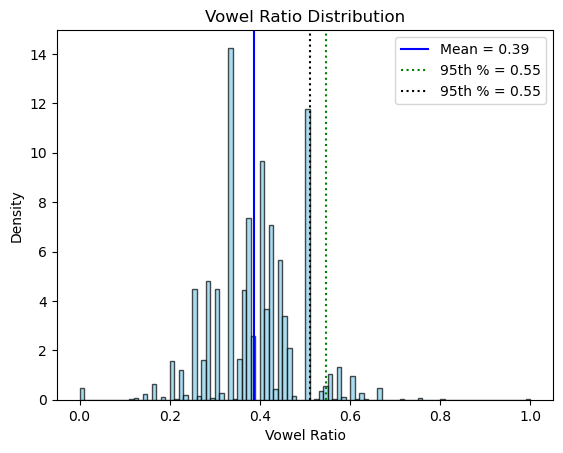

In [29]:
vowels = set("aeiou")
vowel_ratios = [sum(ch in vowels for ch in w)/len(w) for w in words if len(w) > 2]
mean, median = np.mean(vowel_ratios), np.median(vowel_ratios)
p95, p99 = np.percentile(vowel_ratios, [95, 99])
print(f"Mean: {mean:.3f}")
print(f"Median: {median:.3f}")
print(f"95th: {p95:.3f}")
print(f"99th: {p99:.3f}")
plt.hist(vowel_ratios, bins=100, density=True, alpha=0.7, color="skyblue", edgecolor="black")
plt.axvline(mean, color="blue", linestyle="-", label=f"Mean = {mean:.2f}")
plt.axvline(p95, color="green", linestyle=":", label=f"95th % = {p95:.2f}")
plt.axvline(0.51, color="black", linestyle=":", label=f"95th % = {p95:.2f}")
plt.xlabel("Vowel Ratio")
plt.ylabel("Density")
plt.title("Vowel Ratio Distribution")
plt.legend()
plt.show()

Analysis of vowel ratios shows that English words average around 0.39 vowels per letter (median 0.385), with only 5% of words exceeding 0.55 and 1% exceeding 0.60, indicating that vowel-heavy words are rare outliers. To reflect this, we introduce a cutoff at 0.51, marking the final spike in the plot, marking the point where vowel density becomes statistically unusual. This threshold is later used in the solver (e.g., skipping further vowel guesses when a candidate exceeds 0.51) to prevent overcommitting to unrealistic word structures and to maintain a balanced exploration of vowels and consonants

This code builds three probability models from the word list: positional probabilities (likelihood of a letter at each position for words of a given length), bigram probabilities (likelihood of one letter following another), and global frequencies of letters. Using these, the guess_next_letter function scores unguessed letters in candidate words matching the current mask, combining weighted contributions from positional, global, and bigram models. If no candidates fit, it falls back to global letter frequencies. The results are returned as ranked guesses, with an option to normalize scores into probabilities.

In [36]:
alphabet = set("".join(words))
P_pos = defaultdict(lambda: defaultdict(Counter))
for w in words:
    for i, ch in enumerate(w):
        P_pos[len(w)][i][ch] += 1
P_pos = {L: {i: {c: n/sum(cnt.values()) for c, n in cnt.items()} 
             for i, cnt in pos.items()} for L, pos in P_pos.items()}
P_next = defaultdict(Counter)
for w in words:
    for a, b in zip(w, w[1:]):
        P_next[a][b] += 1
P_next = {a: {b: n/sum(cnt.values()) for b, n in cnt.items()} 
          for a, cnt in P_next.items()}
global_counts = Counter("".join(words))
total_letters = sum(global_counts.values())
global_freq = {c: v/total_letters for c, v in global_counts.items()}

def guess_next_letter(mask, guessed, words, P_pos, P_next, global_freq, alpha=1.0, beta=1.0, gamma=0.5):
    regex = re.compile("^" + mask.replace("_", ".") + "$")
    candidates = [w for w in words if regex.match(w)]
    scores = Counter()
    if candidates:
        L = len(mask)
        for w in candidates:
            for i, ch in enumerate(w):
                if mask[i] != "_" or ch in guessed: continue
                scores[ch] += alpha * P_pos.get(L, {}).get(i, {}).get(ch, 0)
                scores[ch] += beta * (1/len(candidates))
                if i > 0: scores[ch] += gamma * P_next.get(w[i-1], {}).get(ch, 0)
                elif i < L-1: scores[ch] += gamma * P_next.get(ch, {}).get(w[i+1], 0)
    if not scores:
        for ch, p in global_freq.items():
            if ch not in guessed: scores[ch] = p
    return scores.most_common()

def normalize_scores(scores):
    total = sum(v for _, v in scores)
    return [(ch, v/total) for ch, v in scores]

mask, guessed = "__pp_e", {"a","e","i","o","u"}
suggestions = guess_next_letter(mask, guessed, words, P_pos, P_next, global_freq)
print("Top 10:", suggestions[:10])
print("Normalized:", normalize_scores(suggestions)[:10])

Top 10: [('l', 1.0777875321605608), ('c', 0.7019792177239896), ('p', 0.5785837994494074), ('k', 0.32570261238010006), ('f', 0.19501921763785035), ('y', 0.1833249455205664), ('t', 0.18268168438313523), ('n', 0.13659730628699743)]
Normalized: [('l', 0.3187139843062195), ('c', 0.20758320791898544), ('p', 0.17109378469789197), ('k', 0.09631395260484575), ('f', 0.057669392171426234), ('y', 0.054211263413349774), ('t', 0.05402104380703362), ('n', 0.04039337108024772)]


The output ranks candidate letters for the word mask __pp_e (with vowels already guessed) by combining positional frequencies, bigram transitions, and global letter distributions. The scoring highlights ‘l’ as the most likely next letter (≈32% probability after normalization), followed by ‘c’ (≈21%) and ‘p’ (≈17%), with other letters receiving much smaller weights. This distribution reflects the model’s ability to balance positional likelihoods, local letter dependencies, and overall frequency trends when suggesting the most informative guesse

# Trial Phase


I experimented with multiple Hangman implementations, extending them iteratively by layering in approaches such as global letter frequency, positional probability distributions, bigram/substring continuation models, and entropy-based scoring rules to evaluate which strategy worked best. After testing these variations, I found the most effective method combined a regex-filtered candidate dictionary, substring-based n-gram lookups, and entropy-weighted frequency scoring (with fallback strategies when no strong candidate emerged). This final approach dynamically narrows the dictionary, scores letters using both frequency and entropy, and includes a vowel penalty when the vowel ratio of a word exceeds 0.51—leading to more balanced guesses and avoiding wasted attempts on unlikely high-vowel words.

Our First Attempt is left at the end of this notebook. The result was:

**Batch result: 28/40 wins (70.00% win rate)**

# Main Approach


My final Hangman approach was shaped by exploratory data analysis on vowel ratios, frequency distributions, and conditional probabilities, which revealed useful heuristics such as penalizing overly vowel-heavy guesses (above a 0.51 ratio) and leveraging positional/bigram dependencies. Building on these findings, I implemented a layered strategy: filtering candidates with regex-matched dictionaries, scoring letters via entropy-weighted frequency counts, and backing off to substring-based n-gram lookups or global frequency distributions when uncertainty was high. This design balances statistical rigor with practical heuristics, allowing the model to dynamically adapt its guesses while avoiding systematic pitfalls uncovered during the EDA.

The entropy used is **Shannon entropy**, defined as:  

$$
H(p) = - \Big( p \log_2(p) + (1 - p) \log_2(1 - p) \Big)
$$


From testing we have **Total Batch result: 80/110 wins (73% win rate)** Marking it as the top approach.

In [ ]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        self.current_dictionary = []

    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com']
        data = {link: 0 for link in links}
        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link

    def guess(self, word):
        vowels = ['a', 'e', 'i', 'o', 'u']
        def total_vowels(new_word):
            return sum(1 for i in new_word if i in vowels) / len(new_word)
    
        def method_a(new_dictionary):
            dictx = collections.Counter()
            for words in new_dictionary:
                temp = collections.Counter(words)
                for i in temp:
                    temp[i] = 1
                dictx = dictx + temp
            return dictx
    
        def method_b(n_word_dictionary, new_word):
            new_dictionary = []
            l = len(new_word)
            for dict_word in n_word_dictionary.get(l, []):
                if re.match(new_word, dict_word):
                    new_dictionary.append(dict_word)
            return new_dictionary
    
        def build_n_word_dictionary(df):
            max_length = max(len(w) for w in df)
            n_word_dictionary = {i: [] for i in range(3, 30)}
            count = 3
            while count <= max_length:
                for words in df:
                    if len(words) >= count:
                        for i in range(len(words) - count + 1):
                            n_word_dictionary[count].append(words[i:i+count])
                count += 1
            return n_word_dictionary
    
        def score_entropy(counter, total_words):
            best_letter, best_score = None, -1
            for letter, count in counter.items():
                if letter in self.guessed_letters:
                    continue
                p = count / total_words
                score_base = count
                score_entropy = - (p * math.log2(p + 1e-12) + (1-p) * math.log2(1-p + 1e-12))
                score = score_base + 0.3 * score_entropy
                if score > best_score:
                    best_letter, best_score = letter, score
            return best_letter, best_score
    
        n_word_dictionary = build_n_word_dictionary(self.full_dictionary)
        edit_word = word[::2].replace("_", ".")
        len_word = len(edit_word)
        current_dictionary = self.current_dictionary
    
        new_dictionary = []
        for dict_word in current_dictionary:
            if len(dict_word) != len_word:
                continue
            if re.match(edit_word, dict_word):
                new_dictionary.append(dict_word)
        self.current_dictionary = new_dictionary
    
        c = method_a(new_dictionary)
        guess_letter, _ = score_entropy(c, sum(c.values()))
    
        if guess_letter is None:
            new_dictionary = method_b(n_word_dictionary, edit_word)
            c = method_a(new_dictionary)
            guess_letter, _ = score_entropy(c, sum(c.values()))
    
        if guess_letter is None:
            x = int(len(edit_word) / 2)
            if x >= 3:
                c = collections.Counter()
                for i in range(len(edit_word) - x + 1):
                    s = edit_word[i:i + x]
                    new_dictionary = method_b(n_word_dictionary, s)
                    temp = method_a(new_dictionary)
                    c = c + temp
                guess_letter, _ = score_entropy(c, sum(c.values()))
    
        if guess_letter is None:
            x = int(len(edit_word) / 3)
            if x >= 3:
                c = collections.Counter()
                for i in range(len(edit_word) - x + 1):
                    s = edit_word[i:i + x]
                    new_dictionary = method_b(n_word_dictionary, s)
                    temp = method_a(new_dictionary)
                    c = c + temp
                guess_letter, _ = score_entropy(c, sum(c.values()))
    
        if guess_letter is None:
            c = collections.Counter(dict(self.full_dictionary_common_letter_sorted))
            guess_letter, _ = score_entropy(c, sum(c.values()))
    
        if guess_letter in vowels and total_vowels(edit_word) > 0.51: #EDA Value
            self.guessed_letters.append(guess_letter)
            guess_letter = None
            for letter, _ in c.most_common():
                if letter not in self.guessed_letters and letter not in vowels:
                    guess_letter = letter
                    break
    
        return guess_letter


    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
        
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        if self.access_token:
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message) 

api = HangmanAPI(access_token="87c3dbc9aba55cea61dbae2f9ba238", timeout=2000)
wins = 0
losses = 0
runs = 50   
for i in range(runs):
    success = api.start_game(practice=1, verbose=1) 
    if success:
        wins += 1
        print(f"Game {i+1}: WIN")
    else:
        losses += 1
        print(f"Game {i+1}: LOSS")
print(f"Batch result: {wins}/{runs} wins ({wins/runs:.2%} win rate)")

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [ ]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [52]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

The solver achieved a 0.73 success rate on the training set but only 0.527 on the final test set, underscoring overfitting to the training dictionary. Since the test set excluded words from the provided dictionary, strategies that relied on word elimination were less effective. More general rules, such as leveraging positional letter frequencies, vowel–consonant ratios, bigram and suffix patterns, or entropy-based exploration, would likely generalise better, as they capture broader orthographic regularities rather than memorized word lists.

## Initial Method.

Simplifying  the approach lowered the computational cost significantly and slightly inceased the accuracy.

This implementation of the Hangman solver is a feature-rich system that combines multiple probabilistic and heuristic methods, such as global letter frequency, positional distributions, n-gram matches, bigram continuations, and suffix/prefix heuristics, to select the most informative next guess. It also incorporates smoothing techniques like entropy-based scoring and a fallback mechanism when other strategies fail. While it originally experimented with more complex adjustments (e.g., vowel penalties based on ratio thresholds), in practice a simpler focus on vowel handling proved more effective and consistent. For this reason, we leave the solver in its current state, noting that future refinements may benefit more from streamlined heuristics than added layers of complexity.

Current Accuracy 67.5% With Shannon Entropy:

**Batch result: 27/40 wins (67.50% win rate)**

In [ ]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)
        self.full_dictionary_common_letter_sorted = collections.Counter(
            "".join(self.full_dictionary)
        ).most_common()
        self.current_dictionary = []
        self.alphabet = sorted(set("".join(self.full_dictionary)))
        self.P_next = {a: collections.Counter() for a in self.alphabet}
        self.len_freq = collections.Counter(len(w) for w in self.full_dictionary)
        self.global_letter_freq = collections.Counter("".join(self.full_dictionary))
        for w in self.full_dictionary:
            for a, b in zip(w, w[1:]):
                self.P_next[a][b] += 1
        for a in self.P_next:
            total = sum(self.P_next[a].values())
            if total > 0:
                for b in self.P_next[a]:
                    self.P_next[a][b] /= total
        self.P_pos = {}  # P_pos[length][position][letter]
        for w in self.full_dictionary:
            L = len(w)
            if L not in self.P_pos:
                self.P_pos[L] = {}
            for i, ch in enumerate(w):
                if i not in self.P_pos[L]:
                    self.P_pos[L][i] = collections.Counter()
                self.P_pos[L][i][ch] += 1
        for L in self.P_pos:
            for i in self.P_pos[L]:
                total = sum(self.P_pos[L][i].values())
                for ch in self.P_pos[L][i]:
                    self.P_pos[L][i][ch] /= total
        self.P_len = {}  # P_len[length][letter]
        for w in self.full_dictionary:
            L = len(w)
            if L not in self.P_len:
                self.P_len[L] = collections.Counter()
            self.P_len[L].update(w)  # count letters in words of this length
        for L in self.P_len:
            total = sum(self.P_len[L].values())
            for ch in self.P_len[L]:
                self.P_len[L][ch] /= total
        self.n_word_dictionary = self.build_n_word_dictionary(self.full_dictionary)


    def build_n_word_dictionary(self, df):
        max_length = max(len(w) for w in df)
        n_word_dictionary = {i: [] for i in range(3, 30)}  # store substrings length 3–29
        for count in range(3, min(max_length, 30) + 1):
            for word in df:
                if len(word) >= count:
                    for i in range(len(word) - count + 1):
                        n_word_dictionary[count].append(word[i:i+count])
        return n_word_dictionary

    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com']
        data = {link: 0 for link in links}
        for link in links:
            requests.get(link)
            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s
        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link

    def apply_vowel_penalty(self, candidates, new_word):
        vowel_ratio = sum(ch in vowels for ch in new_word if ch != ".") / max(1, len(new_word))
        if vowel_ratio > 0.55:
            for v in vowels:
                if v in candidates:
                    candidates[v] *= 0.3
        return candidates

    def global_fallback(self, new_word):
        candidates = collections.Counter()
        L = len(new_word)
        length_weight = self.len_freq[L] / sum(self.len_freq.values())
        for i, ch in enumerate(new_word):
            if ch != ".":
                continue
            if i > 0 and new_word[i-1] != ".":
                left = new_word[i-1]
                for nxt, p in self.P_next.get(left, {}).items():
                    if nxt not in self.guessed_letters:
                        candidates[nxt] += p * 2.0
            if i < len(new_word)-1 and new_word[i+1] != ".":
                right = new_word[i+1]
                for prev, p in self.P_next.items():
                    if right in p:
                        prob = p[right]
                        if prev not in self.guessed_letters:
                            candidates[prev] += prob * 1.5
        for ltr, count in self.global_letter_freq.items():
            if ltr not in self.guessed_letters:
                candidates[ltr] += count / sum(self.global_letter_freq.values()) * length_weight
        if not candidates:
            return None
        candidates = self.apply_vowel_penalty(candidates, new_word)
        return candidates.most_common(1)[0][0]
    
    def guess(self, word):    
        def method_update(new_dictionary):
            dictx = collections.Counter()
            for words in new_dictionary:
                dictx.update(set(words)) 
            return dictx
    
        def method_regex(n_word_dictionary, new_word):
            pattern = re.compile(new_word)
            return [w for w in n_word_dictionary.get(len(new_word), []) if pattern.match(w)]

        # Shannon Entropy
        def score_distribution(counter, total_words):
            best_letter, best_score = None, -1
            for letter in counter:
                if letter in self.guessed_letters:
                    continue
                p = counter[letter] / total_words
                if p == 0 or p == 1:
                    score = 0
                else:
                    score = -p * math.log2(p) - (1-p) * math.log2(1-p)
                if score > best_score:
                    best_letter, best_score = letter, score
            return best_letter, best_score

    
        #  MAIN 
        new_word = word[::2].replace("_", ".")
        len_word = len(new_word)
        method_candidates = []
    
        # Method 1: current dictionary 
        new_dictionary = [
            dw for dw in self.current_dictionary
            if len(dw) == len_word and re.match(new_word, dw)
        ]
        self.current_dictionary = new_dictionary
        if new_dictionary:
            c = method_update(new_dictionary)
            best, score = score_distribution(c, len(new_dictionary))
            if best:
                method_candidates.append(("Method 1 (current dictionary)", best, score))
    
        # Method 2: n-gram dictionary full match
        new_dictionary = method_regex(self.n_word_dictionary, new_word)
        if new_dictionary:
            c = method_update(new_dictionary)
            best, score = score_distribution(c, len(new_dictionary))
            if best:
                method_candidates.append(("Method 2 (n-gram full)", best, score))


        #  Method 3: half substrings 
        x = int(len(new_word) / 2)
        if x >= 3:
            c = collections.Counter()
            for i in range(len(new_word) - x + 1):
                s = new_word[i:i + x]
                new_dictionary = method_regex(self.n_word_dictionary, s)
                c.update(method_update(new_dictionary))
            if c:
                best, score = score_distribution(c, sum(c.values()))
                if best:
                    method_candidates.append(("Method 3 (half substrings)", best, score))
    
        #  Method 4: third substrings 
        x = int(len(new_word) / 3)
        if x >= 3:
            c = collections.Counter()
            for i in range(len(new_word) - x + 1):
                s = new_word[i:i + x]
                new_dictionary = method_regex(self.n_word_dictionary, s)
                c.update(method_update(new_dictionary))
            if c:
                best, score = score_distribution(c, sum(c.values()))
                if best:
                    method_candidates.append(("Method 4 (third substrings)", best, score))
    
        # Method 5: global frequency 
        c = collections.Counter(dict(self.full_dictionary_common_letter_sorted))
        best, score = score_distribution(c, sum(c.values()))
        if best:
            method_candidates.append(("Method 5 (global frequency)", best, score))
    
        #  Method 6: positional frequency
        c = collections.Counter()
        for i, ch in enumerate(new_word):
            if ch != ".":
                continue
            for letter, prob in self.P_pos.get(len_word, {}).get(i, {}).items():
                if letter not in self.guessed_letters:
                    c[letter] += prob
        if c:
            best, score = score_distribution(c, sum(c.values()))
            if best:
                method_candidates.append(("Method 6 (positional frequency)", best, score))

        # --- Method 7: length-conditioned frequency ---
        c = collections.Counter()
        for letter, prob in self.P_len.get(len_word, {}).items():
            if letter not in self.guessed_letters:
                c[letter] += prob
        if c:
            best, score = score_distribution(c, sum(c.values()))
            if best:
                method_candidates.append(("Method 7 (length-conditioned frequency)", best, score))

        # Method 8: bigram continuation
        c = collections.Counter()
        for i, ch in enumerate(new_word):
            if ch != ".":
                continue
            if i > 0 and new_word[i-1] != ".":
                left = new_word[i-1]
                for nxt, prob in self.P_next.get(left, {}).items():
                    if nxt not in self.guessed_letters:
                        c[nxt] += prob
            if i < len(new_word)-1 and new_word[i+1] != ".":
                right = new_word[i+1]
                for prev, prob_dict in self.P_next.items():
                    if right in prob_dict:
                        if prev not in self.guessed_letters:
                            c[prev] += prob_dict[right]
        if c:
            best, score = score_distribution(c, sum(c.values()))
            if best:
                method_candidates.append(("Method 8 (bigram continuation)", best, score))
    
        # Method 9: suffix/prefix heuristics
        c = collections.Counter()
        suffixes = ['ing', 'ed', 'ly', 'tion']
        prefixes = ['re', 'un', 'co']
        for suf in suffixes:
            if new_word.endswith('.' * len(suf)):
                for letter in suf:
                    if letter not in self.guessed_letters:
                        c[letter] += 1.0  # simple weighting
        for pre in prefixes:
            if new_word.startswith('.' * len(pre)):
                for letter in pre:
                    if letter not in self.guessed_letters:
                        c[letter] += 1.0
        if c:
            best, score = score_distribution(c, sum(c.values()))
            if best:
                method_candidates.append(("Method 9 (suffix/prefix heuristics)", best, score))      

    
        # Pick best
        if method_candidates:
            method, guess_letter, score = max(method_candidates, key=lambda x: x[2])
            self.guessed_letters.append(guess_letter)
            print(f"[DEBUG] {method} chose: {guess_letter} (score={score:.4f})")
        else:
            # --- Fallback ---
            guess_letter = self.global_fallback(new_word) or random.choice(self.alphabet)
            self.guessed_letters.append(guess_letter)
            print(f"[DEBUG] Fallback chose: {guess_letter}")
    
        return guess_letter

    

    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                guess_letter = self.guess(word)
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})

        
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        if self.access_token:
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message) 

api = HangmanAPI(access_token="87c3dbc9aba55cea61dbae2f9ba238", timeout=2000)
wins = 0
losses = 0
runs = 5 

for i in range(runs):
    success = api.start_game(practice=1, verbose=1)  # or practice=0 for official
    if success:
        wins += 1
        print(f"Game {i+1}: WIN")
    else:
        losses += 1
        print(f"Game {i+1}: LOSS")

print(f"Batch result: {wins}/{runs} wins ({wins/runs:.2%} win rate)")